# Regression model for Wagga Wagga

Build a RF regression model for floor height predition in Wagga Wagga.

* Use surveyed data to build a model, tuned with cross validation
* Apply the model to all surveyed and other council provided data
* Model training excludes data points where floor height is above 2m

In [1]:
import geopandas as gpd

from matplotlib import pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Use only points matched to footprint
df_footprint = gpd.read_file('wagga_FFH_footprint_geometry.geojson')

In [4]:
df_footprint.head()

,X,Y,Residental,Storeys,Ground_Lev,Floor_Leve,Street,Floor_Height,surveyed,index_nexis,LID,LONGITUDE,LATITUDE,STE_CODE,STATE_ABBREV,STATE_NAME,SA1_CODE,SA2_CODE,SA2_Name,SUBURB,POSTCODE,LGA_CODE,LGA_NAME,UCL_CODE,UCL_NAME,NEXIS_USE_II,NEXIS_CONSTRUCTION_TYPE,LOCAL_YEAR_BUILT,NEXIS_YEAR_BUILT,NEXIS_WALL_TYPE,GENERIC_EXT_WALL,flood_vulnerability_function_id,floor_height_(m),floor_height_(cm),LOCAL_NO_OF_STOREYS,NEXIS_NO_OF_STOREYS,REPLACEMENT_VALUE,CONTENTS_VALUE,BATCH,distance,index_right,min_height_ahd,max_height_ahd,geometry
0,537819.72,6113103.86,R,0,185.291,185.791,Hammond Ave,0.500,True,14647,RU25K537823611311555,147.415128,-35.124102,1,NSW,New South Wales,11303126705,113031267,Wagga Wagga - East,EAST WAGGA WAGGA,2650,17750,Wagga Wagga,112019,Wagga Wagga,Residential,SH,1990,1987 - 1991,Veneer Masonry,brick_veneer,FCM7,0.247,24.7,0,1.0,935420,77100,20240506-2121.b13ac.15-9,12.454922,42243,184.977,185.413,"POLYGON ((537841.086 6113104.489, 537840.651 6..."
1,538357.34,6113059.35,R,1,182.526,182.850,Eunony Bridge Rd,0.324,True,14574,RU25K538361611306455,147.421025,-35.124546,1,NSW,New South Wales,11303126713,113031267,Wagga Wagga - East,GUMLY GUMLY,2652,17750,Wagga Wagga,131001,Remainder of State/Territory (NSW),Residential,SH,1994,1992 - 1996,Veneer Masonry,brick_veneer,FCM7,0.174,17.4,0,1.0,669557,77100,20240506-2121.b13ac.15-9,6.006174,42292,182.436,182.610,"POLYGON ((538369.460 6113071.045, 538355.309 6..."
2,537001.62,6112555.90,R,0,181.376,181.626,Copland St,0.250,True,13309,RU25K537002611255055,147.406137,-35.129227,1,NSW,New South Wales,11303126705,113031267,Wagga Wagga - East,EAST WAGGA WAGGA,2650,17750,Wagga Wagga,112019,Wagga Wagga,Residential,SH,2022,2022 - 2026,Veneer Masonry,brick_veneer,FCM7,0.190,19.0,0,1.0,925970,77100,20240506-2121.b13ac.15-9,5.360446,41779,181.324,181.724,"POLYGON ((536998.023 6112558.316, 536995.514 6..."
3,538697.76,6113590.44,R,0,190.592,190.792,Gumly Rd,0.200,True,15647,LPI_514518342,147.424739,-35.119769,1,NSW,New South Wales,11303126713,113031267,Wagga Wagga - East,GUMLY GUMLY,2652,17750,Wagga Wagga,131001,Remainder of State/Territory (NSW),Residential,SH,1994,1992 - 1996,Fibre Cement,lightweight_cladding,FCM1,2.212,221.2,0,1.0,662943,77100,20240506-2121.b13ac.15-9,4.398444,42379,189.557,190.601,"POLYGON ((538693.985 6113610.314, 538694.041 6..."
4,538679.97,6112849.75,R,0,182.466,182.766,Sturt Hwy,0.300,True,14143,GNAF_GANSW712724692,147.424482,-35.126570,1,NSW,New South Wales,11303126713,113031267,Wagga Wagga - East,Gumly Gumly,2652,17750,Wagga Wagga,131001,Remainder of State/Territory (NSW),Residential,SH,1994,1992 - 1996,Timber,lightweight_cladding,FCM1,3.826,382.6,0,1.0,366524,77100,20240506-2121.b13ac.15-9,12.571391,42281,182.264,182.427,"POLYGON ((538684.886 6112837.070, 538685.512 6..."


In [5]:
df_footprint['Floor_Height_DEM'] = df_footprint['Floor_Leve'] - df_footprint['min_height_ahd']

In [6]:
df_footprint['range_dem'] = df_footprint['max_height_ahd'] - df_footprint['min_height_ahd']

### Inspect and clean up categorical fields 

Ensure no duplication in categorical fields. If necessary, make all lower case; take first letter to combine y/yes, n/no etc

In [7]:
cate_cols = ['NEXIS_CONSTRUCTION_TYPE', 'NEXIS_YEAR_BUILT', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id']
print(cate_cols)
for col in cate_cols:
    #df_footprint[col] = df_footprint[col].str.lower()
    print(df_footprint[col].unique())

['NEXIS_CONSTRUCTION_TYPE', 'NEXIS_YEAR_BUILT', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id']
['SH']
['1987 - 1991' '1992 - 1996' '2022 - 2026' '2002 - 2006' '2017 - 2021'
 '1982 - 1986' '1972 - 1976' '2012 - 2016' '1997 - 2001' '1962 - 1971'
 '1977 - 1981' '2007 - 2011']
['Veneer Masonry' 'Fibre Cement' 'Timber' 'Cavity and Solid Masonry'
 'RC or RM' 'Metal Sheeting' 'Precast Concrete']
['brick_veneer' 'lightweight_cladding' 'cavity_masonry']
['FCM7' 'FCM1' 'FCM8' 'FCM10' 'FCM4' 'FCM9' 'FCM11' 'FCM6' 'FCM5' 'FCM3']


In [8]:
df_footprint[cate_cols].describe()

,NEXIS_CONSTRUCTION_TYPE,NEXIS_YEAR_BUILT,NEXIS_WALL_TYPE,GENERIC_EXT_WALL,flood_vulnerability_function_id
count,1872,1872,1872,1872,1872
unique,1,12,7,3,10
top,SH,1987 - 1991,Veneer Masonry,brick_veneer,FCM7
freq,1872,1393,1394,1394,1078


## Build and tune a regression model

* Use selected catagorical and numerical featrures
* Remove highly correlated features


In [9]:
# Features and target
cat_features = ['NEXIS_YEAR_BUILT'] #['NEXIS_CONSTRUCTION_TYPE', 'NEXIS_YEAR_BUILT', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id']
num_features = ['range_dem'] #['min_height_ahd', 'max_height_ahd', 'range_dem']
target = 'Floor_Height'

X_raw = df_footprint[cat_features + num_features]
y = df_footprint[target]

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
X_encoded_categorical = encoder.fit_transform(X_raw[cat_features])

# Normalize numeric features
scaler = StandardScaler()
X_normalized_numeric = scaler.fit_transform(X_raw[num_features])


# Concatenate the encoded categorical features with the normalized numeric features
X = np.hstack((X_encoded_categorical, X_normalized_numeric))


In [10]:
ffh_limit = 1.

In [11]:
# use only surveyed data for training

X_surveyed = X[df_footprint['surveyed'].values & (df_footprint[target]<ffh_limit).values]
y_surveyed = y[df_footprint['surveyed'].values & (df_footprint[target]<ffh_limit).values]

In [12]:
# Remove outliers
X_lt_2m = X[(df_footprint[target]<ffh_limit).values]
y_lt_2m = y[(df_footprint[target]<ffh_limit).values]

In [13]:
# Helper function to remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return X.drop(columns=to_drop, axis=1)

# Custom transformer to integrate with pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_keep = [column for column in X_df.columns if not any(upper_triangle[column] > self.threshold)]
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X).loc[:, self.to_keep] if self.to_keep else X


In [14]:
# Use all data (less than 2m FFH) to tune and find best model

# Pipeline including CorrelationFilter
pipeline = Pipeline([
    #('correlation_filter', CorrelationFilter(threshold=1)),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10, 15, 20]
}

# Cross-validation with GridSearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_lt_2m, y_lt_2m)

# Best model from GridSearch
best_model = grid_search.best_estimator_

# Output best parameters and RMSE on full dataset
print("Best Parameters:", grid_search.best_params_)
print("Training RMSE:", np.sqrt(mean_squared_error(y, best_model.predict(X))))

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 20, 'regressor__n_estimators': 200}
Training RMSE: 0.10209573459531815


In [15]:
# Extract feature importances after correlation filter
#remaining_features = best_model.named_steps['correlation_filter'].to_keep
feature_importances = best_model.named_steps['regressor'].feature_importances_
# Get the feature names (assuming you have them stored somewhere)
cat_feature_names = np.array(encoder.get_feature_names_out())
all_feature_names = np.concatenate((cat_feature_names, num_features))#[remaining_features]
print("Total number of features encoded:", len(cat_feature_names)+len(num_features))
print("Total number of features kept:", len(all_feature_names))

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances.round(3)
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Total number of features encoded: 13
Total number of features kept: 13
                         Feature  Importance
12                     range_dem       0.771
5   NEXIS_YEAR_BUILT_1992 - 1996       0.115
10  NEXIS_YEAR_BUILT_2017 - 2021       0.048
8   NEXIS_YEAR_BUILT_2007 - 2011       0.024
1   NEXIS_YEAR_BUILT_1972 - 1976       0.014
0   NEXIS_YEAR_BUILT_1962 - 1971       0.010
3   NEXIS_YEAR_BUILT_1982 - 1986       0.010
7   NEXIS_YEAR_BUILT_2002 - 2006       0.007
6   NEXIS_YEAR_BUILT_1997 - 2001       0.001
2   NEXIS_YEAR_BUILT_1977 - 1981       0.000
4   NEXIS_YEAR_BUILT_1987 - 1991       0.000
9   NEXIS_YEAR_BUILT_2012 - 2016       0.000
11  NEXIS_YEAR_BUILT_2022 - 2026       0.000


### Apply model to survey data and all data points

Explained Variance (R^2): 0.5363
RMSE: 0.11961964849906988


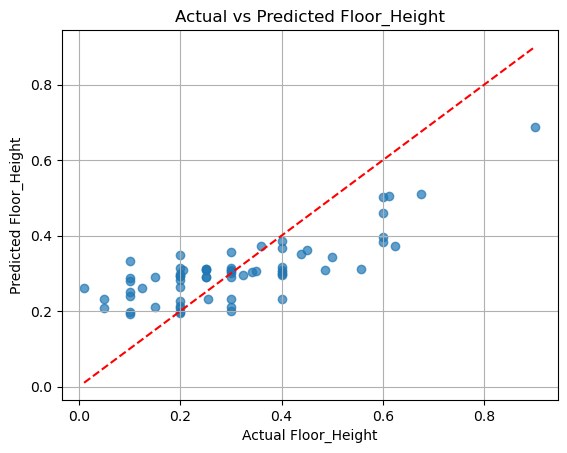

In [16]:
# Fit the best model on surveyed data
best_model.fit(X_surveyed, y_surveyed)

# Get predictions for all surveyed data
predictions = best_model.predict(X_surveyed)

# Calculate explained variance
explained_variance = r2_score(y_surveyed, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_surveyed, predictions))
print(f"RMSE: {rmse}")

plt.scatter(y_surveyed, predictions, alpha=0.7)
plt.plot([y_surveyed.min(), y_surveyed.max()], [y_surveyed.min(), y_surveyed.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)

Explained Variance (R^2): 0.2703
RMSE: 0.02853217537702329


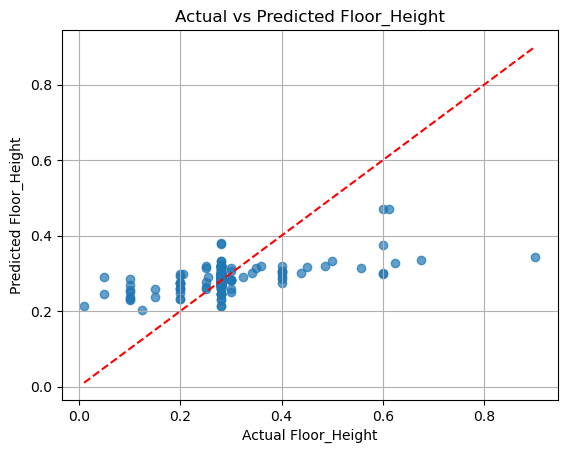

In [17]:
# Fit the best model on all data points
best_model.fit(X_lt_2m, y_lt_2m)

# Get predictions for all data points
predictions = best_model.predict(X_lt_2m)

# Calculate explained variance
explained_variance = r2_score(y_lt_2m, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_lt_2m, predictions))
print(f"RMSE: {rmse}")

plt.scatter(y_lt_2m, predictions, alpha=0.7)
plt.plot([y_lt_2m.min(), y_lt_2m.max()], [y_lt_2m.min(), y_lt_2m.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)

<Axes: ylabel='Frequency'>

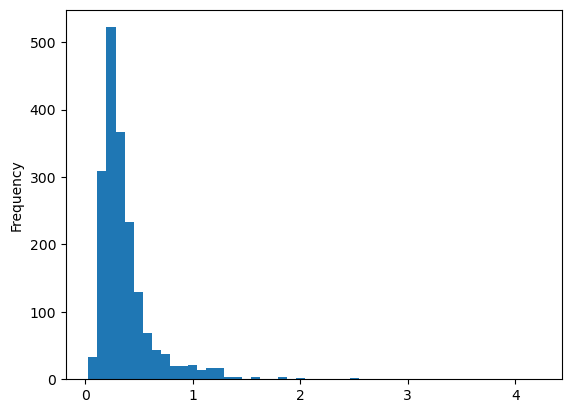

In [18]:
df_footprint['range_dem'].plot.hist(bins=50)